Rows,Cols: (83448, 2)
label
1    43910
0    39538
Name: count, dtype: int64


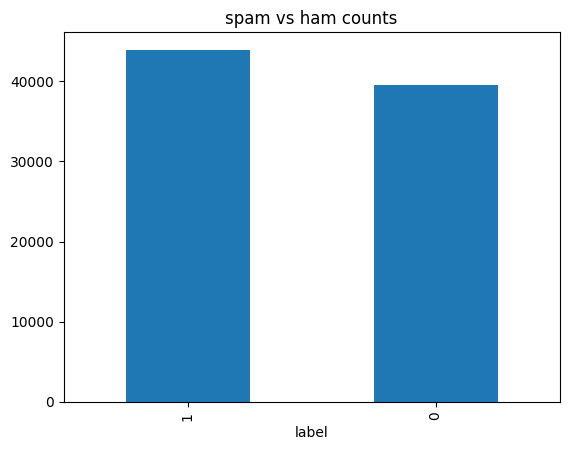

In [ ]:
# Step 0: load and basic EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
# Load dataset from Hugging Face
dataset = load_dataset("iamthearafatkhan/email-spam-dataset", split="train")

df = dataset.to_pandas()
#df = pd.read_csv("combined_data.csv")    # change to your filename
print("Rows,Cols:", df.shape)
print(df['label'].value_counts())

# quick plot of class balance
df['label'].value_counts().plot(kind='bar', title='spam vs ham counts')
plt.show()


In [2]:
# Step 1: preprocessing
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def clean_text(s, remove_stopwords=True):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)            # remove HTML
    s = re.sub(r'http\S+', ' url ', s)        # urls => token
    s = re.sub(r'[^a-z0-9\s]', ' ', s)        # punctuation -> space
    s = re.sub(r'\s+', ' ', s).strip()
    if remove_stopwords:
        s = ' '.join(w for w in s.split() if w not in stop)
    return s

df = df.dropna(subset=['text','label']).drop_duplicates().reset_index(drop=True)
df['clean'] = df['text'].apply(clean_text)
# Ensure labels are 0/1
if df['label'].dtype == object:
    df['y'] = df['label'].map(lambda x: 1 if str(x).lower().strip() in ('spam','1','true','yes') else 0)
else:
    df['y'] = df['label'].astype(int)

print("After cleaning:", df.shape)
df.sample(5)


After cleaning: (83448, 4)


,label,text,clean,y
16649,0,on escapenumber escapenumber escapenumber zack...,escapenumber escapenumber escapenumber zack we...,0
28167,0,start date : 1 / 25 / 02 ; hourahead hour : 12...,start date 1 25 02 hourahead hour 12 ancillary...,0
73035,1,we present for you eshop of best digital goods...,present eshop best digital goods give escapenu...,1
40773,1,glad to see you look at the assortment of our ...,glad see look assortment new online drug store...,1
17038,0,some emerging documents ( early days ) but goo...,emerging documents early days good information...,0


In [3]:
from sklearn.model_selection import train_test_split
X = df['clean']
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (66758,) Test: (16690,)


In [4]:
# Step 3: TF-IDF (used for NB, SVM)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

# Optionally keep a Count vectorizer for experiments
bow_vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow  = bow_vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (66758, 20000)


In [5]:
# Step 4: Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)

nb_preds = nb_model.predict(X_test_tfidf)
nb_probs = nb_model.predict_proba(X_test_tfidf)[:,1]

print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, nb_probs))

# Save model + vectorizer
#import joblib
#joblib.dump(nb_model, "nb_model.joblib")
#joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")


Naive Bayes
Accuracy: 0.9744757339724386
              precision    recall  f1-score   support

           0     0.9648    0.9819    0.9733      7908
           1     0.9835    0.9678    0.9756      8782

    accuracy                         0.9745     16690
   macro avg     0.9741    0.9748    0.9744     16690
weighted avg     0.9746    0.9745    0.9745     16690

ROC-AUC: 0.9968562258963735


In [6]:
# Step 5: Linear SVM with CalibratedClassifierCV for probabilities
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Note: don't always scale TF-IDF; we used with_mean=False scaler only if needed. Many use raw TF-IDF.
linear = LinearSVC(max_iter=10000)
svm_clf = CalibratedClassifierCV(linear, cv=3)   # calibrate for predict_proba
svm_clf.fit(X_train_tfidf, y_train)  # uses TF-IDF directly

svm_preds = svm_clf.predict(X_test_tfidf)
svm_probs = svm_clf.predict_proba(X_test_tfidf)[:,1]

print("SVM")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, svm_probs))

#joblib.dump(svm_clf, "svm_clf.joblib")


SVM
Accuracy: 0.9913121629718394
              precision    recall  f1-score   support

           0     0.9928    0.9889    0.9908      7908
           1     0.9900    0.9935    0.9918      8782

    accuracy                         0.9913     16690
   macro avg     0.9914    0.9912    0.9913     16690
weighted avg     0.9913    0.9913    0.9913     16690

ROC-AUC: 0.9987370128834132


In [7]:
# Step 6: LSTM (Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

MAX_WORDS = 20000
MAX_LEN = 150
EMB_DIM = 128

tokenizer_keras = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_keras.fit_on_texts(X_train)

Xtr_seq = tokenizer_keras.texts_to_sequences(X_train)
Xte_seq = tokenizer_keras.texts_to_sequences(X_test)
Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding='post', truncating='post')
Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding='post', truncating='post')

model_lstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMB_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_lstm.fit(Xtr_pad, y_train.values, validation_split=0.1, epochs=5, batch_size=64, callbacks=[es])

dl_probs = model_lstm.predict(Xte_pad).flatten()
dl_preds = (dl_probs > 0.5).astype(int)

print("LSTM")
print("Accuracy:", accuracy_score(y_test, dl_preds))
print(classification_report(y_test, dl_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, dl_probs))

# Save tokenizer and model
#import json
#with open("keras_tokenizer.json","w") as f:
    #f.write(tokenizer_keras.to_json())
#model_lstm.save("lstm_model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 459s 472ms/step - accuracy: 0.8274 - loss: 0.4023 - val_accuracy: 0.9585 - val_loss: 0.1483
Epoch 2/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 481s 460ms/step - accuracy: 0.9670 - loss: 0.1138 - val_accuracy: 0.9825 - val_loss: 0.0599
Epoch 3/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 433s 462ms/step - accuracy: 0.9889 - loss: 0.0383 - val_accuracy: 0.9832 - val_loss: 0.0568
Epoch 4/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 435s 464ms/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.9880 - val_loss: 0.0467
Epoch 5/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 435s 463ms/step - accuracy: 0.9969 - loss: 0.0120 - val_accuracy: 0.9858 - val_loss: 0.0448
522/522 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step
LSTM
Accuracy: 0.9873576992210905
              precision    recall  f1-score   support

           0     0.9880    0.9853    0.9866      7908
           1     0.9868    0.9892    0.9880      8782

    accuracy                         0.9874     16690
   macro avg     0.9874    0.9873    0.9873     16

In [8]:
!pip show transformers


Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [9]:
# Step 7A: Prepare PyTorch-style Dataset for Trainer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np

model_name = "distilbert-base-uncased"
tokenizer_hf = AutoTokenizer.from_pretrained(model_name)

class TorchSpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TorchSpamDataset(X_train, y_train, tokenizer_hf, max_len=128)
eval_dataset  = TorchSpamDataset(X_test, y_test, tokenizer_hf, max_len=128)

# Step 7B: Load model and training args
model_hf = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # <-- correct for new versions
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='./logs',
    report_to=[]    # set to "wandb" if using wandb (and have wandb.init earlier)
)

# compute_metrics using sklearn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

def compute_metrics_hf(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    # Softmax probs for class 1
    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
    try:
        roc = roc_auc_score(labels, probs[:,1])
    except:
        roc = None
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc}

trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics_hf
)

# If you have GPU and proper torch, this will use it. Else it runs on CPU (slow).
trainer.train()

# Evaluate + preds
res = trainer.evaluate()
pred_out = trainer.predict(eval_dataset)
bert_logits = pred_out.predictions
bert_preds = np.argmax(bert_logits, axis=-1)
# compute probs (softmax)
import torch as t
bert_probs = t.nn.functional.softmax(t.tensor(bert_logits), dim=-1).numpy()[:,1]

print("Transformer (DistilBERT) eval:", res)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.050000,0.049381,0.988676,0.992887,0.985539,0.989199,0.998923


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.050000,0.049381,0.988676,0.992887,0.985539,0.989199,0.998923
2,0.023300,0.048133,0.991492,0.991356,0.992485,0.991920,0.999066
3,0.007700,0.057654,0.990593,0.992463,0.989638,0.991049,0.999022


Transformer (DistilBERT) eval: {'eval_loss': 0.04813260957598686, 'eval_accuracy': 0.9914919113241462, 'eval_precision': 0.9913557779799818, 'eval_recall': 0.9924846276474607, 'eval_f1': 0.9919198816433368, 'eval_roc_auc': 0.9990663741545193, 'eval_runtime': 71.8773, 'eval_samples_per_second': 232.201, 'eval_steps_per_second': 14.525, 'epoch': 3.0}


In [10]:
#399e9ac7b04d7e4a228d1eb1a3eff8cb58b50494
# Step 8: collect metrics for each model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

rows = []
def add_row(name, y_true, preds, probs):
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds, zero_division=0),
        "Recall": recall_score(y_true, preds, zero_division=0),
        "F1": f1_score(y_true, preds, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, probs) if probs is not None else None
    })

add_row("NaiveBayes", y_test, nb_preds, nb_probs)
add_row("SVM", y_test, svm_preds, svm_probs)
add_row("LSTM", y_test, dl_preds, dl_probs)
add_row("DistilBERT", y_test, bert_preds, bert_probs)

comparison_df = pd.DataFrame(rows).set_index("Model")
print(comparison_df)


            Accuracy  Precision    Recall        F1   ROC_AUC
Model                                                        
NaiveBayes  0.974476   0.983453  0.967775  0.975551  0.996856
SVM         0.991312   0.990015  0.993509  0.991759  0.998737
LSTM        0.987358   0.986823  0.989182  0.988001  0.998744
DistilBERT  0.991492   0.991356  0.992485  0.991920  0.999066


<Figure size 1000x600 with 0 Axes>

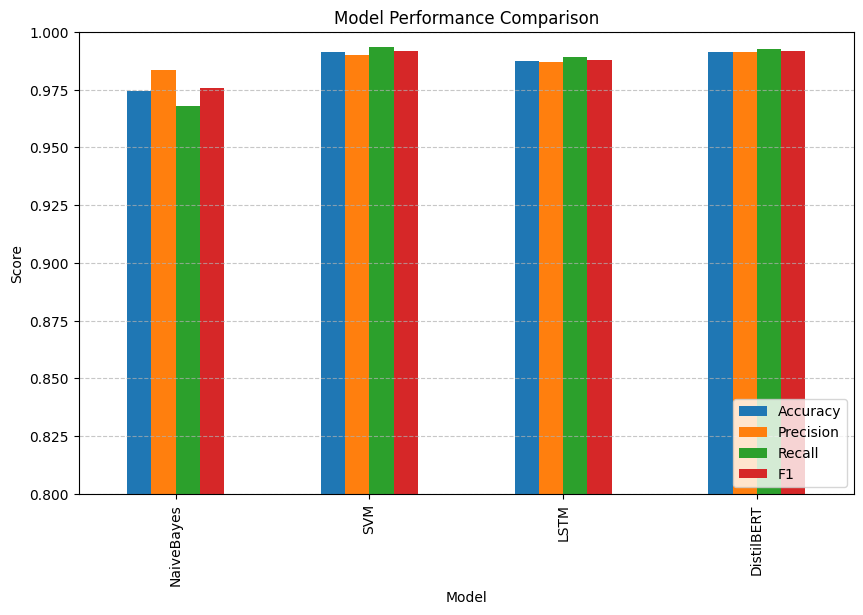

In [11]:
# Step 8B: Visual comparison of model performance
plt.figure(figsize=(10,6))
comparison_df[['Accuracy','Precision','Recall','F1']].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


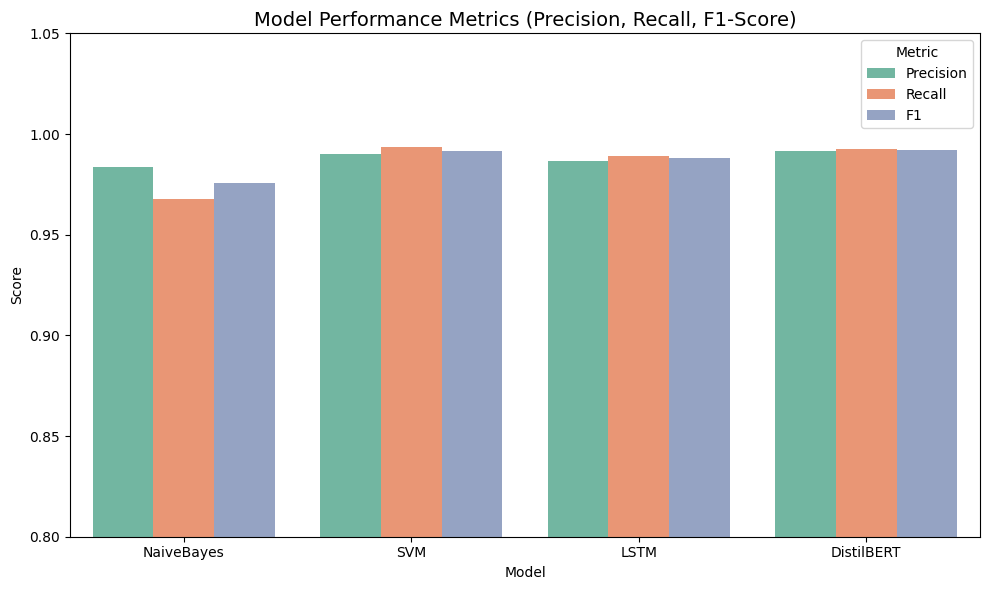

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt dataframe to long form for easy plotting
melted_df = comparison_df.reset_index().melt(
    id_vars="Model",
    value_vars=["Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

# Set up figure
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=melted_df, palette="Set2")

plt.title("Model Performance Metrics (Precision, Recall, F1-Score)", fontsize=14)
plt.ylabel("Score")
plt.ylim(0.8, 1.05)  # optional, zoom in for clarity
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


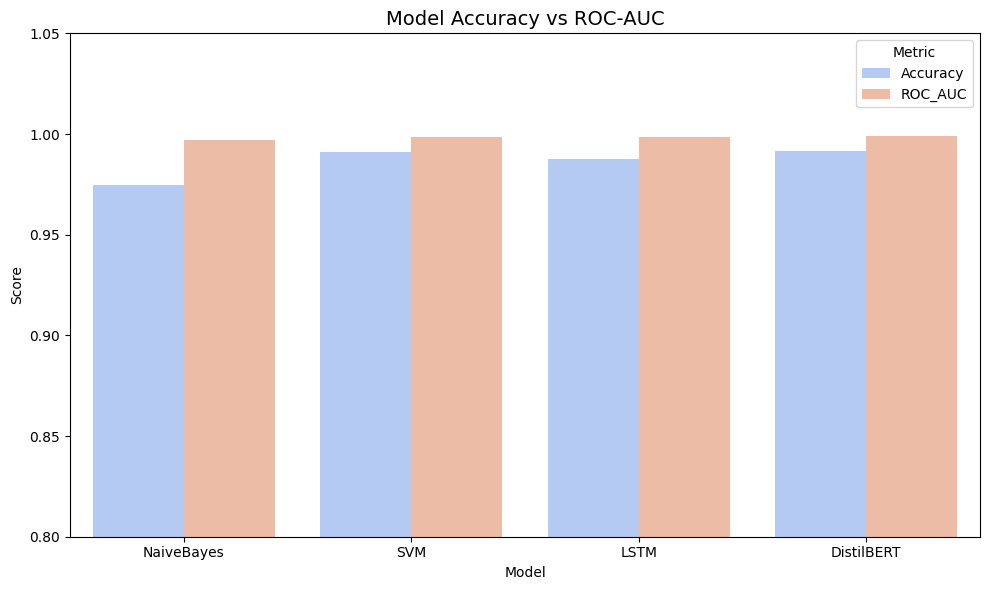

In [13]:
melted_df2 = comparison_df.reset_index().melt(
    id_vars="Model",
    value_vars=["Accuracy", "ROC_AUC"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=melted_df2, palette="coolwarm")
plt.title("Model Accuracy vs ROC-AUC", fontsize=14)
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


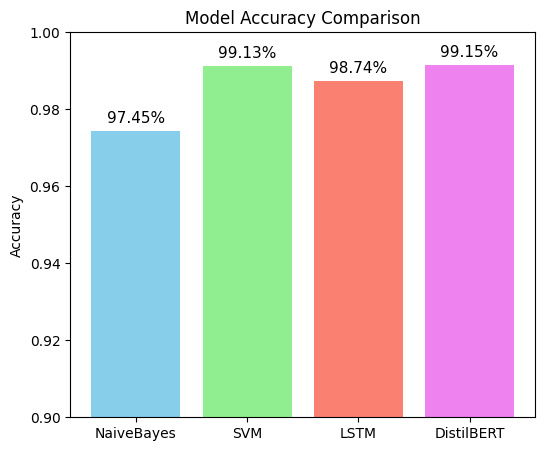

In [14]:
# Step 8C: Accuracy-only comparison
plt.figure(figsize=(6,5))
plt.bar(comparison_df.index, comparison_df['Accuracy'], color=['skyblue','lightgreen','salmon','violet'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
for i, acc in enumerate(comparison_df['Accuracy']):
    plt.text(i, acc + 0.002, f"{acc*100:.2f}%", ha='center', fontsize=11)
plt.show()


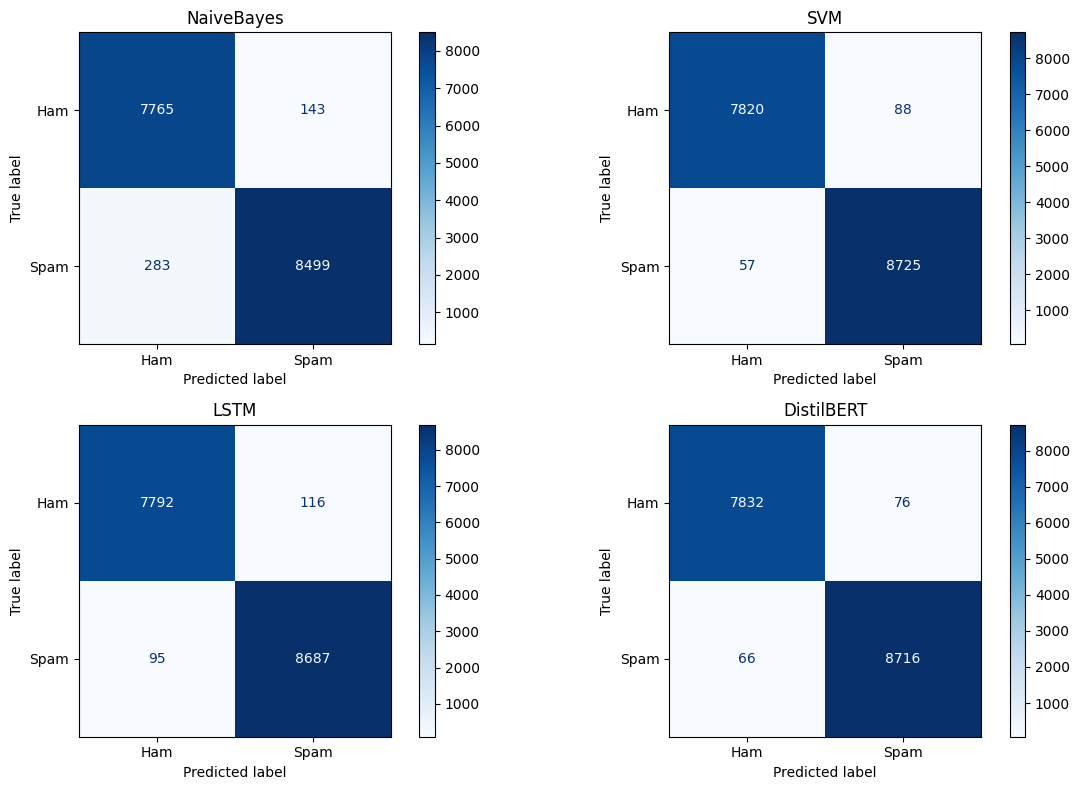

In [15]:
# Step 9: confusion matrices for each model (2x2 grid)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
models = {
    "NaiveBayes": (nb_preds),
    "SVM": (svm_preds),
    "LSTM": (dl_preds),
    "DistilBERT": (bert_preds)
}

plt.figure(figsize=(12,8))
i = 1
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    ax = plt.subplot(2,2,i)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Ham','Spam'])
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    ax.set_title(name)
    i += 1
plt.tight_layout()
plt.show()


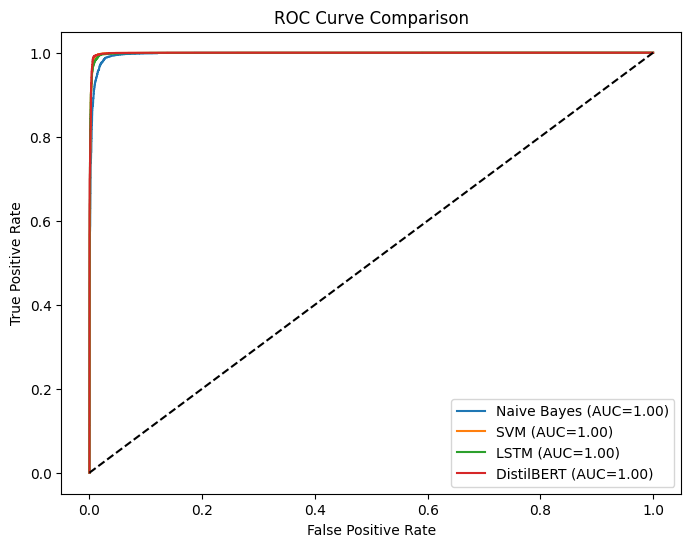

In [16]:
# Step 10: ROC curve for all models
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8,6))

fpr, tpr, _ = roc_curve(y_test, nb_probs); plt.plot(fpr, tpr, label=f"Naive Bayes (AUC={auc(fpr,tpr):.2f})")
fpr, tpr, _ = roc_curve(y_test, svm_probs); plt.plot(fpr, tpr, label=f"SVM (AUC={auc(fpr,tpr):.2f})")
fpr, tpr, _ = roc_curve(y_test, dl_probs);  plt.plot(fpr, tpr, label=f"LSTM (AUC={auc(fpr,tpr):.2f})")
fpr, tpr, _ = roc_curve(y_test, bert_probs);plt.plot(fpr, tpr, label=f"DistilBERT (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


In [18]:
from google.colab import drive
drive.mount('/content/drive')

model_save_path = "/content/drive/MyDrive/distilbert_spam_model"
model_hf.save_pretrained(model_save_path)
tokenizer_hf.save_pretrained(model_save_path)
print(f"✅ Model and tokenizer saved to Drive: {model_save_path}")


Mounted at /content/drive
✅ Model and tokenizer saved to Drive: /content/drive/MyDrive/distilbert_spam_model


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, numpy as np

# Load model and tokenizer
model_path = "/content/drive/MyDrive/distilbert_spam_model"
tokenizer_hf = AutoTokenizer.from_pretrained(model_path)
model_hf = AutoModelForSequenceClassification.from_pretrained(model_path)

# Example prediction
def predict_with_transformer(text, device='cpu'):
    model_hf.to(device)
    enc = tokenizer_hf(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        out = model_hf(**enc)
        probs = torch.nn.functional.softmax(out.logits, dim=-1).cpu().numpy()[0]
        pred = np.argmax(probs)
    label = "SPAM" if pred == 1 else "HAM"
    return label, probs[1]




In [23]:
while True:
    text = input("\nEnter a message (or 'quit' to stop): ")
    if text.lower() == 'quit':
        break
    label, confidence = predict_with_transformer(text)

    print(f"\nPrediction: {label}")
    print(f"Confidence: {confidence*100:.2f}%")



Enter a message (or 'quit' to stop): how?

Prediction: SPAM
Confidence: 91.31%

Enter a message (or 'quit' to stop): quit
